# Testing DEMV on _Wine Quality_ Dataset

- Label: `quality`
- Positive label: `quality=6`
- Unprivileged group: `alcohol=0 (<=10) & type=1 (white)`

Source: [https://archive.ics.uci.edu/ml/datasets/wine+quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)

In [114]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearnex import patch_sklearn

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss

import matplotlib.pyplot as plt
import seaborn as sns

from demv import DEMV
from utils import *

import warnings
warnings.filterwarnings('ignore')

#patch_sklearn()
sns.set_style('whitegrid')

In [115]:
def load_data():
  red = pd.read_csv('data2/winequality-red.csv', sep=';')
  red['type'] = 0
  white = pd.read_csv('data2/winequality-white.csv', sep=';')
  white['type'] = 1
  data = red.append(white)
  data.drop(data[(data['quality']==3)|(data['quality']==9)].index, inplace=True)
  data.loc[data['alcohol'] <= 10, 'alcohol'] = 0
  data.loc[(data['alcohol'] > 10) & (data['alcohol'] != 0), 'alcohol'] = 1
  return data

In [116]:
data = load_data()

<AxesSubplot:>

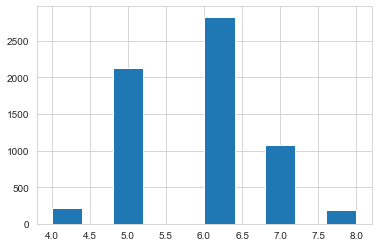

In [117]:
data['quality'].hist()

In [118]:
data = data.loc[ data.quality != 8 ]

In [119]:
label = 'quality'
sensitive_variables = ['alcohol', 'type']
protected_group = {'alcohol': 0, 'type': 1}
positive_label = 6

In [120]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression(n_jobs=-1))
])

## Biased dataset

In [121]:
model, bias_metrics = cross_val(pipeline, data, label, protected_group, sensitive_variables,positive_label=positive_label)

In [122]:
print_metrics(bias_metrics)

Statistical parity:  -0.321  +-  0.04
Disparate impact:  0.535  +-  0.049
Zero one loss:  0.15  +-  0.099
F1 score:  0.539  +-  0.011
Accuracy score:  0.561  +-  0.01


## DEMV dataset

In [123]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [124]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_variables, positive_label=positive_label, debiaser=demv)

In [125]:
print_metrics(demv_metrics)

Statistical parity:  -0.1  +-  0.05
Disparate impact:  0.863  +-  0.066
Zero one loss:  0.105  +-  0.051
F1 score:  0.472  +-  0.015
Accuracy score:  0.517  +-  0.013


## DEMV Evaluation

In [126]:
demv.get_iters()

371

In [127]:
metrics = eval_demv(76, demv.get_iters(), data.copy(), pipeline, label,
                    protected_group, sensitive_variables, positive_label=positive_label)


##  Blackbox Postprocessing 

In [110]:
data = data.sample(frac=1).reset_index(drop=True)

In [111]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_variables, positive_label=positive_label)


Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0065  0.0000
5  0.2581  0.6269
6  0.3846  0.6667
7  0.0563  0.2222

1
      fpr     tpr
4  0.0000  0.1333
5  0.1652  0.5379
6  0.5466  0.7642
7  0.0346  0.2247


And loss is 0.4240


Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0073  0.0000
5  0.2738  0.6271
6  0.3827  0.6290
7  0.0630  0.2500

1
      fpr     tpr
4  0.0000  0.1333
5  0.1755  0.5043
6  0.5708  0.7536
7  0.0354  0.2000


And loss is 0.4431

[0.41486892 0.31610174 0.14948982 0.11953951]
[0.27674126 0.25482911 0.34952531 0.11890432]
[0.14580617 0.09788957 0.46518852 0.29111573]
[0.125852   0.04741526 0.43863315 0.38809959]
[0.41486892 0.23444424 0.24690776 0.10377908]
[0.3095053  0.25482911 0.30072098 0.13494461]
[0.1731014  0.11304416 0.46518852 0.24866591]
[0.10876112 0.05561899 0.44752031 0.38809959]

Pre-adjustment group rates are 

0
      fpr     tpr
4  0.0072  0.0000
5  0.2674  0.6207
6  0.3875  0.6406
7  0.0625  0.2500

1
      fpr     tpr
4  

##  Plot

In [128]:
df = prepareplots(metrics,'wine')

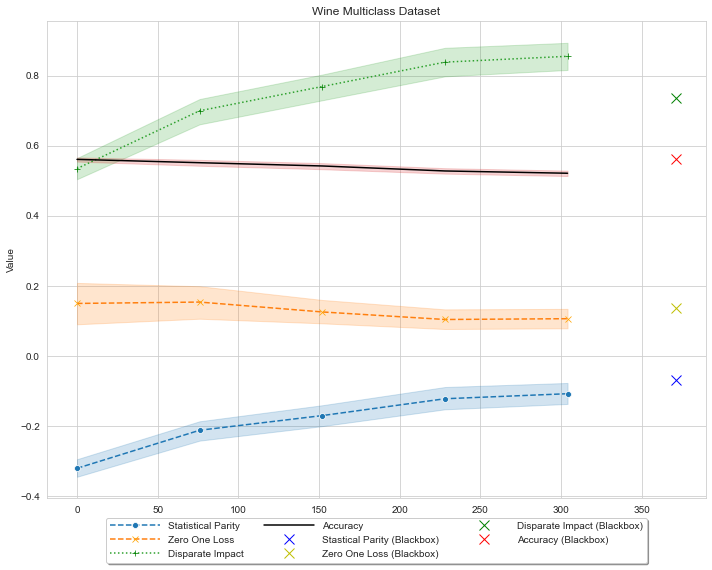

In [129]:
points = preparepoints(blackboxmetrics, demv.get_iters())

plot_metrics_curves(df, points, 'Wine Multiclass Dataset')


In [130]:
unprivpergentage(data,protected_group, demv.get_iters())

Dataset size: 6246
Unprivileged group size: 2052
Percentage of unprivileged group: 32.85302593659942
Number of iterations: 371


In [131]:
save_metrics('blackbox', 'wine', blackboxmetrics)